## Integrantes:
1. Camila Coltriani
2. Luis Dartayet
3. Irania Fuentes
4. Jonathan Fichelson
5. Ornella Cevoli

# Trabajo práctico 2 : Modelo de regresión lineal del dataset Properatti

## Objetivos

El objetivo de este trabajo final es generar y comparar estadisticamente tres modelos de regresion lineal sobre el dataset limpio de Properatti construido en el TP_1; en este, fue planteado la hipotesis que el precio (variable objetivo) de las propiedades iba a estar influenciado principalmente por la superfice y la ubicacion (variables predictoras). 

Con base a esto, se han planteado los siguientes objetivos especificos:
- Explorar el dataset limpio con la finalidad de verificar si debe realizarse una ultima limpieza o pueden utilizase los datos directamente;
- Realizar una visualización general de las distribuciones y relaciones del dataset con la finalidad de determinar la zona, tipo de inmueble y variables predictoras y objetivo para la realizacion de los modelos;
- Construir modelos de regresión lineal simple y multiple e interpretar sus metricas con la finalidad de identificar el que mejor permita obtener una prediccion confiable de la variable objetivo;
- Implementar un modelo de regularización con la finalidad de compararlos y evaluar si existe o no problemas de sobreajuste;
- Determinar el modelo que más se ajusta al comportamiento de los datos analizados. 

In [1]:
#Las librerías utilizadas en este documento son:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn import metrics
from matplotlib.ticker import ScalarFormatter
from matplotlib import gridspec
sns.set()

## Visualización del dataset

In [2]:
# Visualización de la forma y atributos del dataset
data = pd.read_csv("./data/data_limpio_gdf.csv")
print(data.shape)
print("El dataset está compuesto por:", data.shape[0], "filas y",data.shape[1],"columnas.")
data.sample(5)

(45439, 15)
El dataset está compuesto por: 45439 filas y 15 columnas.


,municipio,provincia,lat,lon,sup_m2_total,precio_usd,tipo,ambientes_cat,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,geometry,precio_usd_por_m2_cat
24111,Belgrano,Capital Federal,-34.554701,-58.464096,118.0,405836.00,apartment,4 o mas,3439.288136,1,25,5,4,POINT (-58.464095630200006 -34.5547012114),8
28949,Palermo,Capital Federal,-34.571150,-58.423297,34.0,98656.79,apartment,1,2901.670294,1,227,5,1,POINT (-58.4232966 -34.571149600000005),7
37367,Almagro,Capital Federal,-34.621348,-58.420381,70.0,151000.00,apartment,3,2157.142857,1,6,5,3,POINT (-58.4203806533 -34.6213482616),5
28901,Quilmes,Bs.As. G.B.A. Zona Sur,-34.757884,-58.286320,170.0,260000.00,house,4 o mas,1529.411765,2,260,2,4,POINT (-58.2863204 -34.7578841),2
353,Mar del Plata,Buenos Aires Costa Atlántica,-38.023705,-57.566779,60.0,100000.00,store,1,1666.666667,3,188,3,1,POINT (-57.5667789 -38.0237049),3


### Descripción de las columnas del dataset limpio:

Las columnas que incluye son:

● municipio: ubicacion del inmueble por su municipio/barrios

● provincia: ubicacion del inmueble por provincia

● lat  ●lon: ubicacion de latitud y longitud

● superficie_m2_total: superficie total en m² del inmueble

● price_usd: Precio en dolares del inmueble

● tipo: tipo de inmueble en venta (casa, departamento, ph, tienda)

● ambientes_cat: cantidad de ambientes del inmueble (0, 1, 2, 3 , 4 o más)

● precio_usd_por_m2: Precio en dolares por metro cuadrado (USD/m²: precio dólares / superficie)

● tipo_cat_code: categoria numerica de tipo de inmueble

● municipio_cat_code: categoria numerica de municipios

● provincia_cat_code: categoria numerica de provincia

● tipo_cat_code: categoria numerica de ambientes_cat

● geometry: figura geometrica de latitud y la longitud

● country_name: nombre del país donde ocurre la operacion inmobiliaría

● **precio_usd_por_m2_cat: categoria numerica de precio_usd_por_m2**

# Analisis exploratorio y visualizacion de correlaciones entre las variables

In [3]:
#Revisamos la presencia de datos NaN
data.isna().sum().sort_values()
#La columna "ambientes_cat" quedó con 1248 registros nulos

municipio                   0
provincia                   0
lat                         0
lon                         0
sup_m2_total                0
precio_usd                  0
tipo                        0
precio_usd_por_m2           0
tipo_cat_code               0
municipio_cat_code          0
provincia_cat_code          0
ambientes_cat_code          0
geometry                    0
precio_usd_por_m2_cat       0
ambientes_cat            1248
dtype: int64

In [4]:
#reviso donde están ubicados y a que propiedad pertenecen los registros nulos para saber si afectaran escoger un tipo de inmueble y su zona
mascara_nulos = data["ambientes_cat"].astype(str) == "nan" 
data_nulos = data[mascara_nulos]
data_nulos.loc[:, ["municipio", 'tipo', 'ambientes_cat', "precio_usd"]].sample(7)
#print(data[mascara_nulos].index)

,municipio,tipo,ambientes_cat,precio_usd
36644,Liniers,PH,NaN,210000.0
40423,Almirante Brown,house,NaN,120000.0
37178,Belgrano,apartment,NaN,110000.0
23799,San Miguel,house,NaN,115000.0
35593,Barrio Norte,apartment,NaN,90000.0
40652,Almirante Brown,house,NaN,130000.0
37743,Córdoba,apartment,NaN,180000.0


In [5]:
#agrupamos los registros donde hay nulos
pd.options.display.max_rows = None
data_nulos.groupby(["tipo"])["municipio"].value_counts().sort_values(ascending=False)
#vemos que los nan están distribuidos equitativamente y no están concentrados en una mismo municipio

tipo       municipio                          
apartment  Córdoba                                73
           Rosario                                56
house      Almirante Brown                        55
apartment  Palermo                                33
house      Punilla                                29
           Córdoba                                28
store      Mar del Plata                          28
house      Lomas de Zamora                        26
           San Miguel                             26
           Ituzaingó                              22
           La Matanza                             21
           Morón                                  21
apartment  Villa Carlos Paz                       21
           Barrio Norte                           19
           Belgrano                               18
           Pinamar                                17
           San Miguel                             17
house      Bahía Blanca                           15

In [6]:
#Los elimino p
data.dropna(subset=['ambientes_cat'], inplace=True)
print(data.isna().sum())

municipio                0
provincia                0
lat                      0
lon                      0
sup_m2_total             0
precio_usd               0
tipo                     0
ambientes_cat            0
precio_usd_por_m2        0
tipo_cat_code            0
municipio_cat_code       0
provincia_cat_code       0
ambientes_cat_code       0
geometry                 0
precio_usd_por_m2_cat    0
dtype: int64


In [7]:
#Realizamos una descripcion estadistica del dataset
data.describe()
#existen datos que no permiten ver los estadisticos ya que hay valores de 0 en sup_m2_total e inf en precio_usd_por_m2: eliminarlos

,lat,lon,sup_m2_total,precio_usd,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,precio_usd_por_m2_cat
count,44191.000000,44191.000000,44191.000000,4.419100e+04,4.419100e+04,44191.000000,44191.000000,44191.000000,44191.000000,44191.000000
mean,-34.785068,-59.026417,105.113575,2.209563e+05,inf,1.239234,196.639225,5.586386,2.601480,4.525899
std,1.837082,2.031306,215.745400,3.174576e+05,NaN,0.608211,115.563981,5.823010,1.158737,2.849106
min,-54.806598,-71.665143,0.000000,1.000000e+01,1.176471e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-34.659264,-58.576770,42.000000,8.600000e+04,1.450440e+03,1.000000,100.000000,3.000000,2.000000,2.000000
50%,-34.603594,-58.455215,66.000000,1.350000e+05,2.047619e+03,1.000000,199.000000,5.000000,3.000000,5.000000
75%,-34.553173,-58.387126,122.000000,2.400000e+05,2.812500e+03,2.000000,276.000000,5.000000,4.000000,7.000000
max,-23.137164,-54.580727,30000.000000,1.200000e+07,inf,3.000000,399.000000,27.000000,4.000000,9.000000


In [8]:
#eliminamos del dataset los registros de sup_m2_total con valores de cero
data.drop(data[(data["sup_m2_total"] ==0)].index, inplace=True ,axis=0)

In [9]:
data.describe()

,lat,lon,sup_m2_total,precio_usd,precio_usd_por_m2,tipo_cat_code,municipio_cat_code,provincia_cat_code,ambientes_cat_code,precio_usd_por_m2_cat
count,44163.000000,44163.000000,44163.000000,4.416300e+04,4.416300e+04,44163.000000,44163.000000,44163.000000,44163.000000,44163.000000
mean,-34.785448,-59.026233,105.180219,2.210394e+05,3.201985e+03,1.239363,196.590540,5.582818,2.602292,4.523062
std,1.837280,2.031694,215.797543,3.175383e+05,2.292673e+04,0.608365,115.574172,5.816332,1.158479,2.847780
min,-54.806598,-71.665143,1.000000,1.000000e+01,1.176471e-01,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-34.659311,-58.576394,42.000000,8.600000e+04,1.450000e+03,1.000000,100.000000,3.000000,2.000000,2.000000
50%,-34.603594,-58.455138,66.000000,1.350000e+05,2.046512e+03,1.000000,198.000000,5.000000,3.000000,5.000000
75%,-34.553225,-58.387121,122.000000,2.400000e+05,2.812500e+03,2.000000,276.000000,5.000000,4.000000,7.000000
max,-23.137164,-54.580727,30000.000000,1.200000e+07,2.600000e+06,3.000000,399.000000,27.000000,4.000000,9.000000


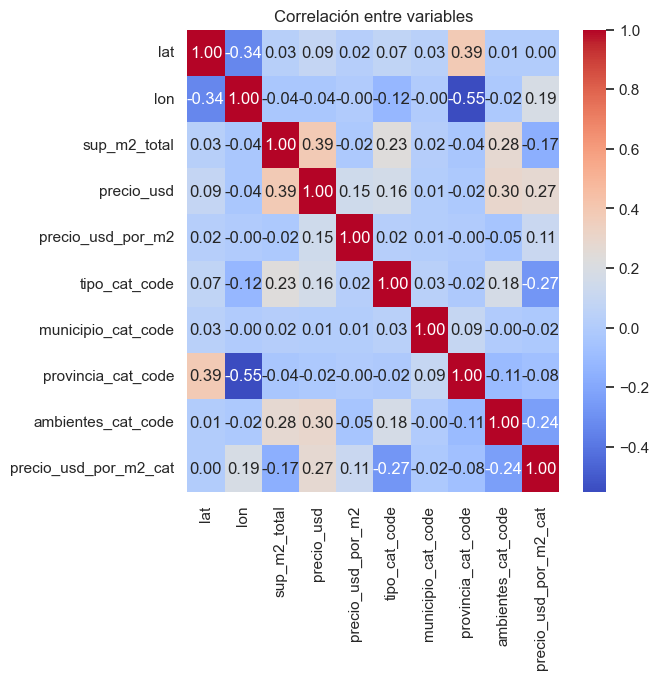

In [10]:
#Vemos la correlacion entre las variables 
data_corr = data.corr()
#graficamos
plt.figure(figsize=(6,6))
sns.heatmap(data_corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlación entre variables")
plt.show()

#puede verse una correlacion significativa entre sup_m2_total y precio_usd (0.39)
#tipo_cat_code / ambientes_cat_code y  precio_usd (0.30)
#precio_usd_por_m2_cat y lon

In [11]:
#graficamos las provincias y municipios que contengan un valor minimo de 500 registros por municipio (para una mejor vsisualizacion)
limite = 500
data = data.copy().groupby(['municipio']).filter(lambda grp: grp.shape[0] > limite)

c:\Users\ornel\anaconda3\envs\DH\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


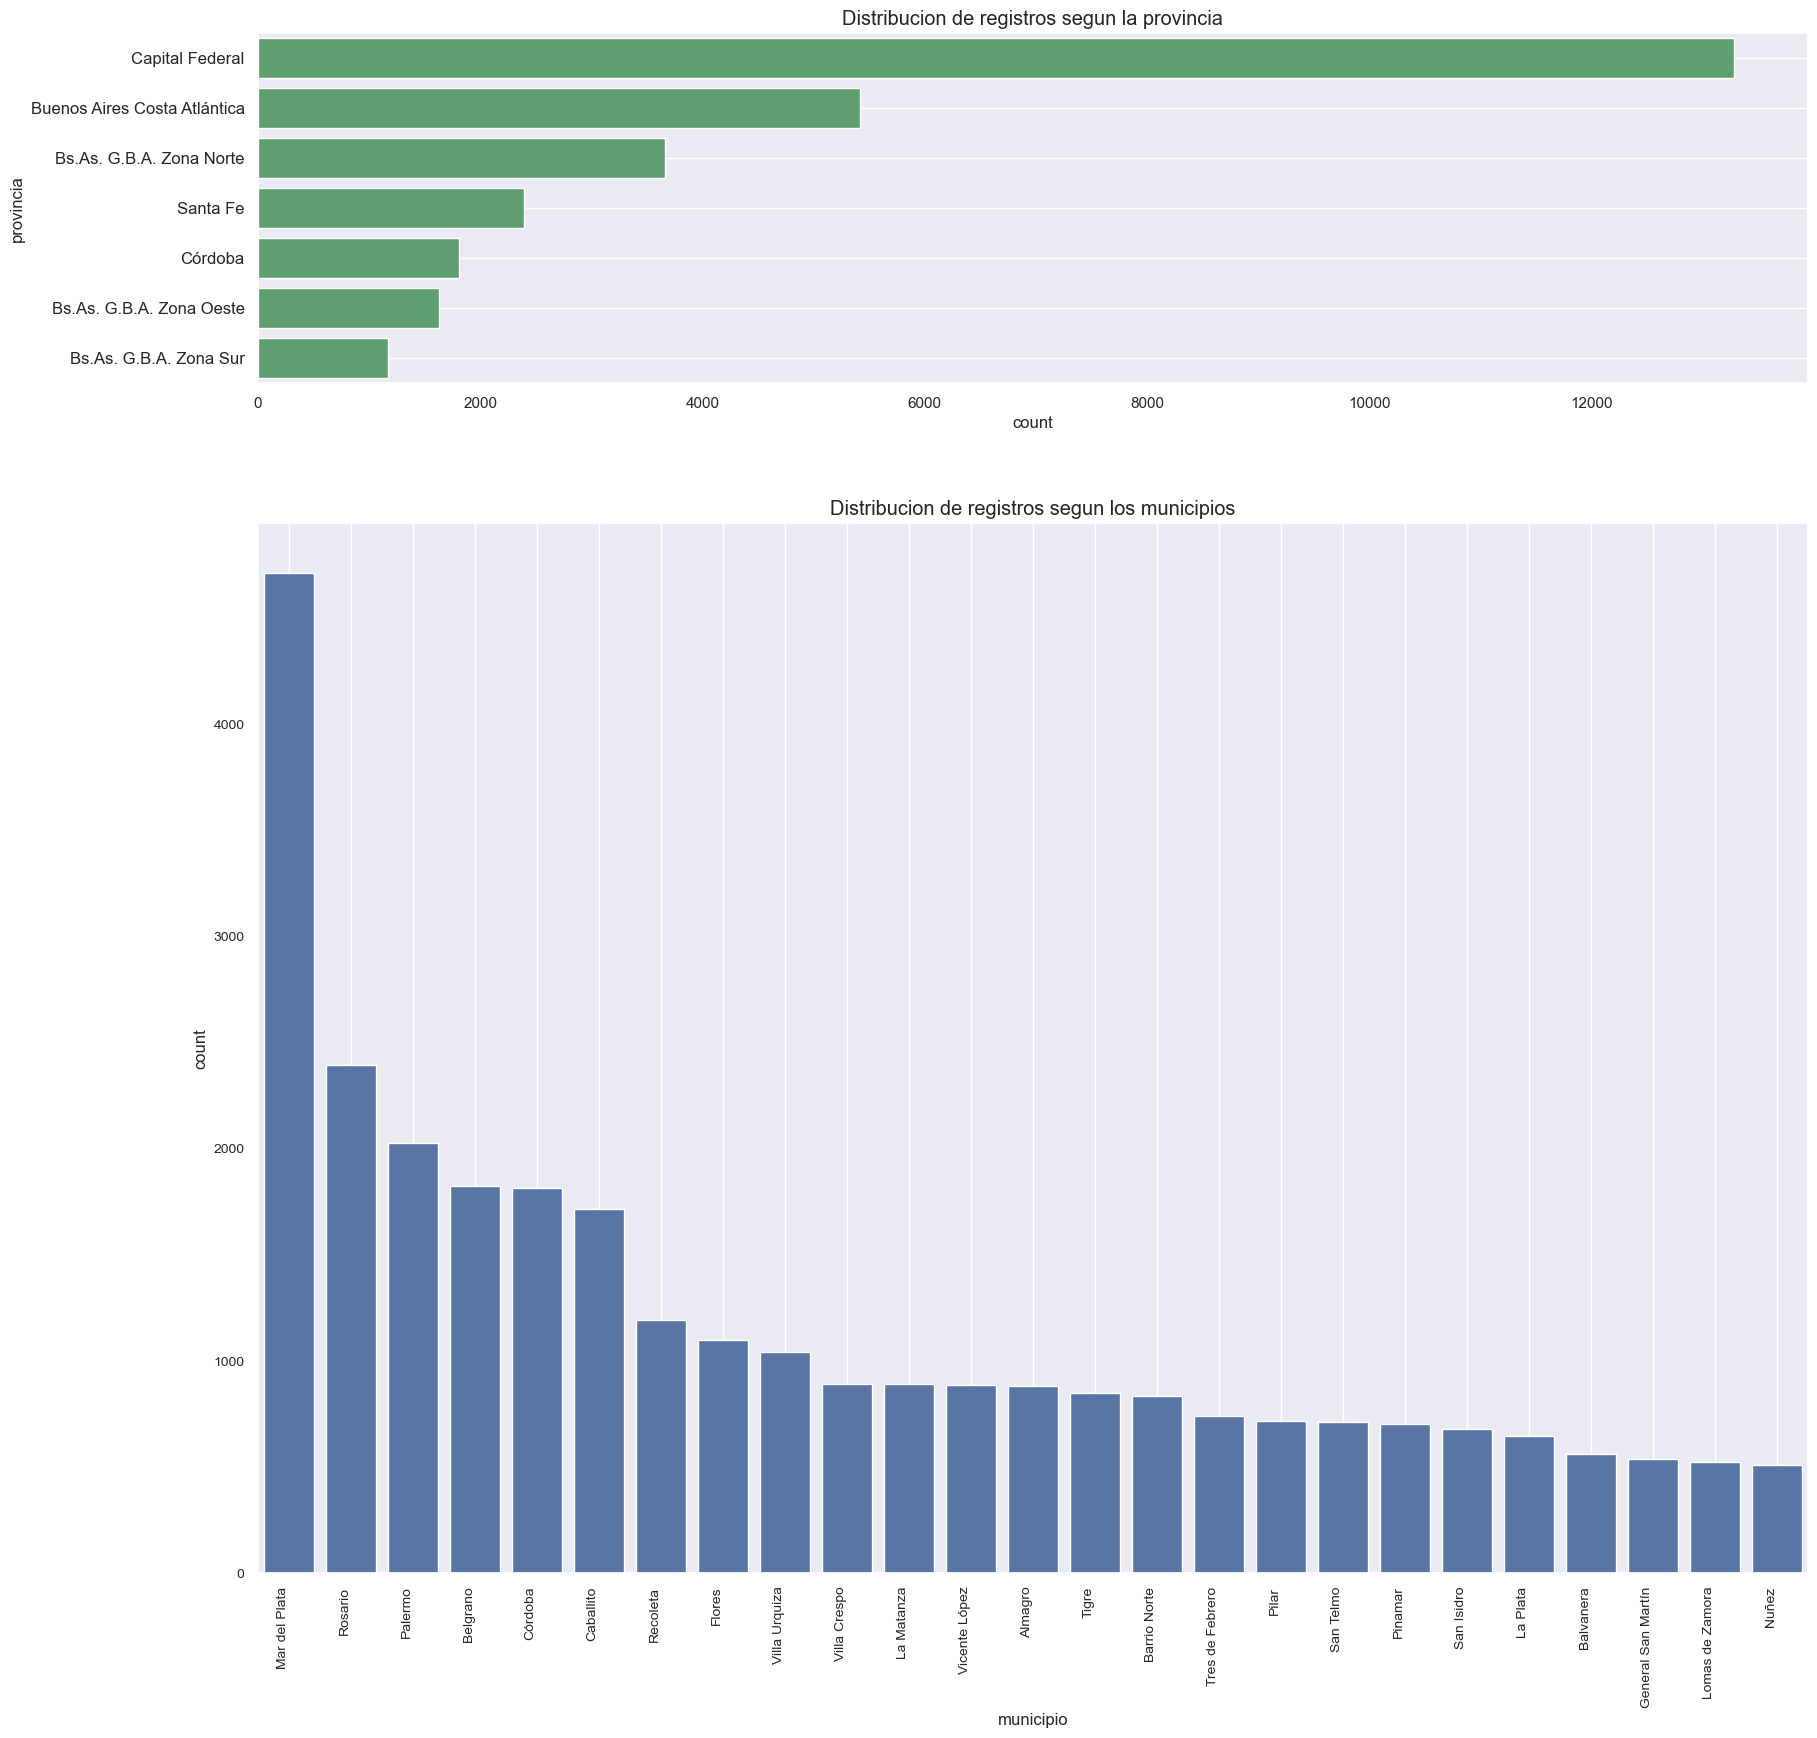

In [12]:
fig= plt.subplots(figsize=(20,20),constrained_layout=True)
grid = gridspec.GridSpec(2, 1, height_ratios=[1, 3])

ax1=plt.subplot(grid[0])
sns.countplot(data=data,y="provincia",order=data["provincia"].value_counts().index ,ax=ax1,color="g")

ax1.set_yticklabels(ax1.get_yticklabels(),fontsize="medium")
ax1.set_title("Distribucion de registros segun la provincia", fontsize= 'large')

ax2=plt.subplot(grid[1])
sns.countplot(data=data,x="municipio",order=data["municipio"].value_counts().index,ax=ax2,color="b")


ax2.set_title("Distribucion de registros segun los municipios", fontsize= 'large')
ax2.set_xticklabels(ax2.get_xticklabels(),rotation=90,ha="right")
plt.xticks(fontsize= 10)
plt.yticks(fontsize= 10)
ax1.grid()
ax2.grid()
plt.show()

La mayor cantidad de registros están Capital Federal para los barrios de Palermo, Belgrano, Caballito..
Consideraremos Capital Federal para la evaluación de los modelos 

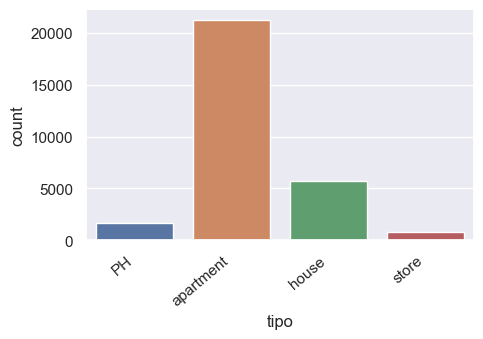

In [13]:
#Revisamos la distribucion de registros por tipo de inmueble
plt.figure(figsize=(5,3))

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
ax = sns.countplot(data = data, x = "tipo")
ax.set_xticklabels(ax.get_xticklabels(),rotation=40,ha="right")
plt.show()

#Apartamentos tiene la mayoria de los datos

Consideraremos apartamentos para la evaluacion de los modelos

In [14]:
#Revisamos la ubicacion de los los tipos de inmueble que contienen la mayor cantidad de registros
pd.options.display.max_rows = None
data.groupby(["municipio"])["tipo"].value_counts().sort_values(ascending=False)

municipio           tipo     
Mar del Plata       apartment    3335
Rosario             apartment    1999
Palermo             apartment    1799
Belgrano            apartment    1670
Caballito           apartment    1559
Recoleta            apartment    1121
Mar del Plata       house         935
Villa Urquiza       apartment     892
Flores              apartment     880
Córdoba             apartment     864
                    house         829
Barrio Norte        apartment     782
Almagro             apartment     766
Villa Crespo        apartment     722
Tigre               house         650
San Telmo           apartment     636
Vicente López       apartment     516
Balvanera           apartment     493
Tres de Febrero     apartment     443
Pilar               house         443
Nuñez               apartment     437
La Matanza          apartment     424
La Plata            apartment     406
Pinamar             apartment     384
San Isidro          house         378
Mar del Plata       

#### Para determinar en que barrio enfocarnos, generaremos una funcion que correremos para los tres barrios enunciados 

In [15]:
# Seleccionamos las columnas que vamos a utilizar y sólo las propiedades de tipo apartamento

df_0 = data[data['tipo'] == 'apartment']
df_0 = data[['municipio', 'sup_m2_total', 'ambientes_cat', 'lat', 'lon', 'precio_usd' ]]
df_0.head()

,municipio,sup_m2_total,ambientes_cat,lat,lon,precio_usd
2,Vicente López,78.0,3,-34.532957,-58.521782,130000.0
3,Belgrano,40.0,1,-34.559873,-58.443362,138000.0
4,Belgrano,60.0,2,-34.559873,-58.443362,195000.0
6,San Isidro,36.0,2,-34.486019,-58.503814,115000.0
9,Tigre,270.0,4 o mas,-34.425087,-58.579659,570000.0


In [16]:
# Extraemos un dataframe por cada columna

df_0_sup_m2_total = df_0[['sup_m2_total', 'precio_usd', 'municipio']]
df_0_ambientes_cat = df_0[['ambientes_cat', 'precio_usd', 'municipio']]
df_0_ubica = df_0[['lat', 'lon', 'precio_usd', 'municipio']]

In [17]:
# Armamos la función para las regresiones lineales

def regresion_lineal(df_0_lr, target, test_size=0.2, random_state=42):
    # Separamos la variable objetivo del resto del dataset
    X = df_0_lr.drop(target, axis=1)
    y = df_0_lr[target]
    
    # Dividimos el dataset en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    # Normalizamos los datos
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Instanciamos el modelo
    model = linear_model.LinearRegression()
    
    # Entrenamos el modelo
    model.fit(X_train, y_train)
    
    # Predecimos con el modelo
    y_pred = model.predict(X_test)
    
    # Calculamos el R2
    r2 = r2_score(y_test, y_pred)
    
    # Imprimimos los resultados
    print('R2: ', r2)
    print('Intercept: ', model.intercept_)
    print('Coeficiente: ', model.coef_[0])
    
    # Graficamos los resultados
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_pred)
    plt.axline(xy1=(0, 0), slope=1, color='red')
    plt.xlabel('Valores reales')
    plt.ylabel('Valores predichos')
    plt.xlim(0, 1000000)
    plt.ylim(0, 1000000)
    plt.show()

In [18]:
# Creamos un array con los municipios

# municipios = df_0['municipio'].unique()
# municipios 

In [83]:
#creamos una mascara para Palermo, Belgrano, Caballito.
municipios = ('Palermo', 'Belgrano', 'Caballito')
municipios

('Palermo', 'Belgrano', 'Caballito')

LUIS -NO ME FUNCIONA EL FILTRO. NO SE PORQUE. PODES ARREGLAR- cuando funciono no me muestra los graficos- en algun lado meti el dedo
PENDIENTE- DE ESTOS GRAFICOS SE VE QUE EL MEJOR PARA PREDECIR ES PALERMO, PORQUE EL R2 DA MEJOR Y PORQUE TIENE MAYOR CANTIDAD DE DATOS.

In [84]:
# Regresión lineal para el precio de las propiedades en función del municipio y la superficie total y guardamos el modelo en un mapa

for municipio in municipios:
    df_0_municipio =df_0_sup_m2_total[df_0_sup_m2_total['municipio'] == municipios]
    if(df_0_municipio.shape[0] > 100):
        df_0_municipio = df_0_municipio.drop('municipio', axis=1)
        print('Municipio: ', municipio)
        regresion_lineal(df_0_municipio, 'precio_usd')
        print('----------------------------------------')

## Correlacion entre la variables del dataset

<Figure size 640x480 with 0 Axes>

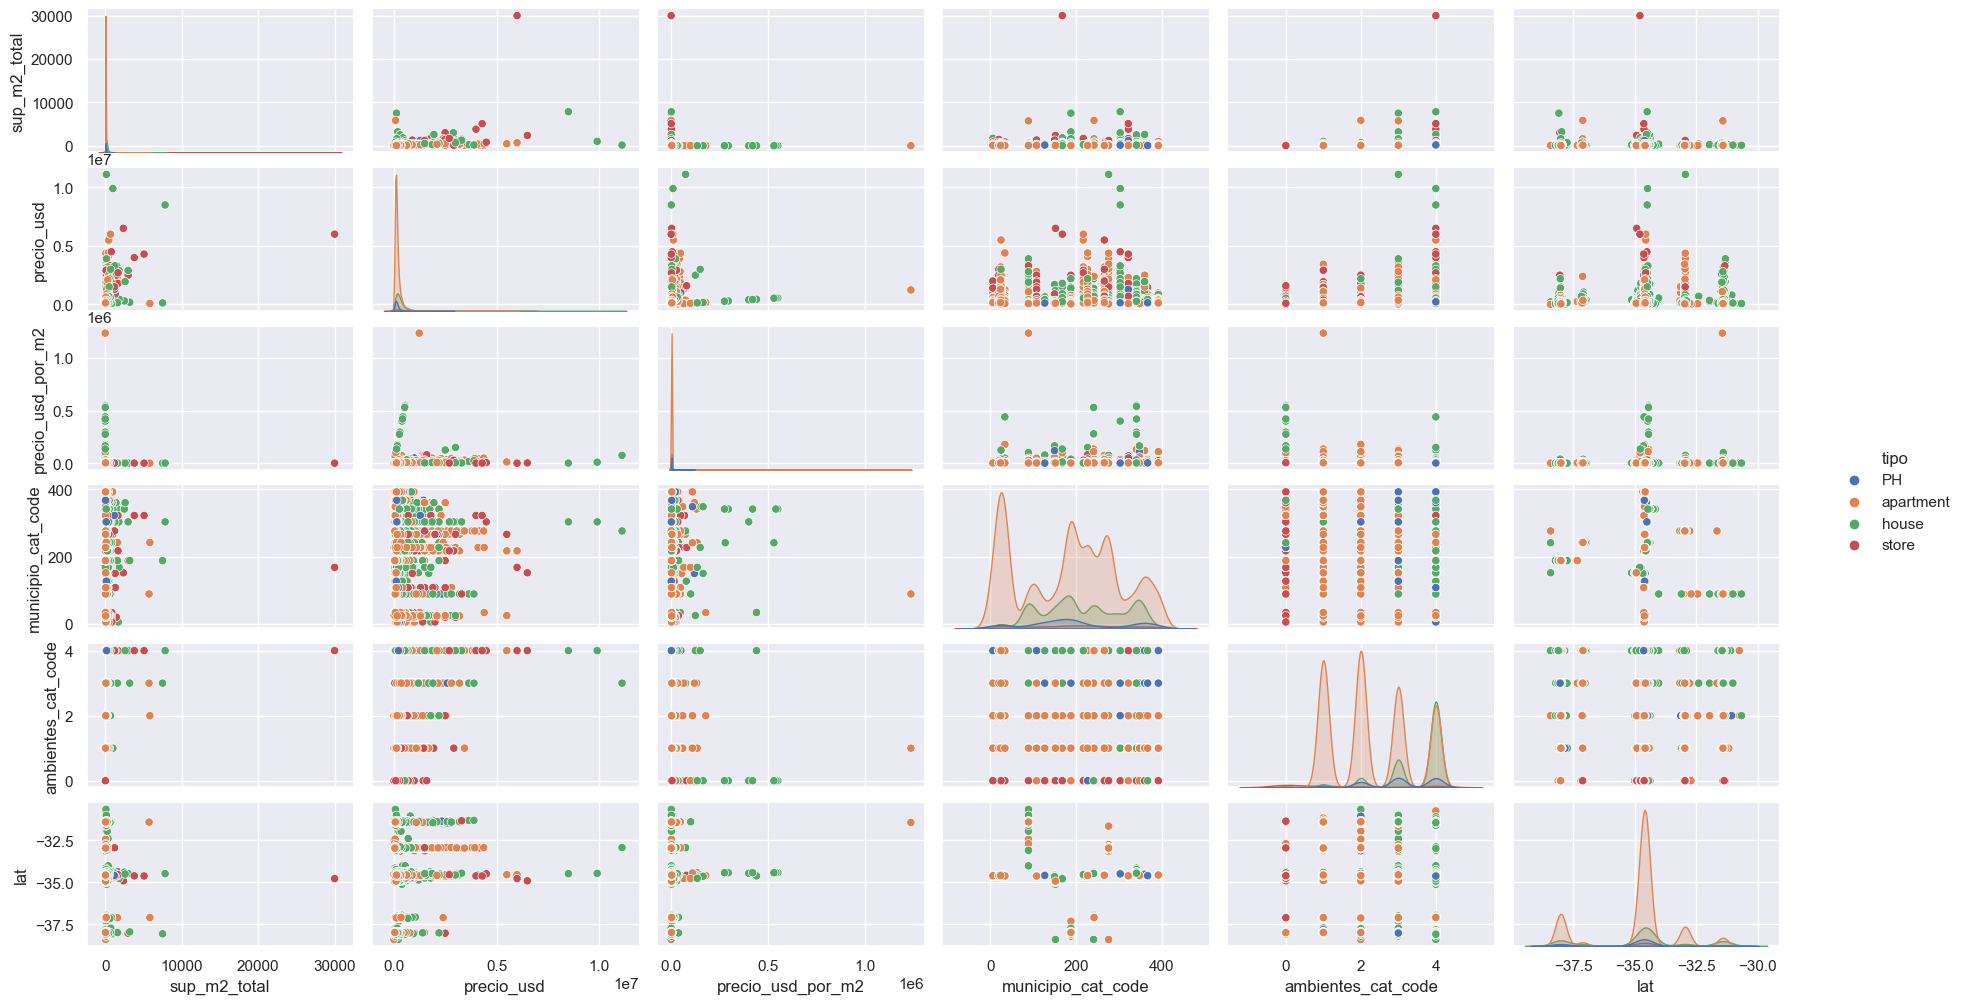

In [21]:
#analizamos la correlación entre cada una de las variables.
figz= plt.figure()
mask_cols= ["tipo","sup_m2_total","precio_usd","precio_usd_por_m2", "ambientes_cat", "municipio_cat_code", "ambientes_cat_code","lat"]
graph=sns.pairplot(data[mask_cols],hue="tipo")
graph.fig.set_size_inches(20,10)
plt.grid()
plt.show()


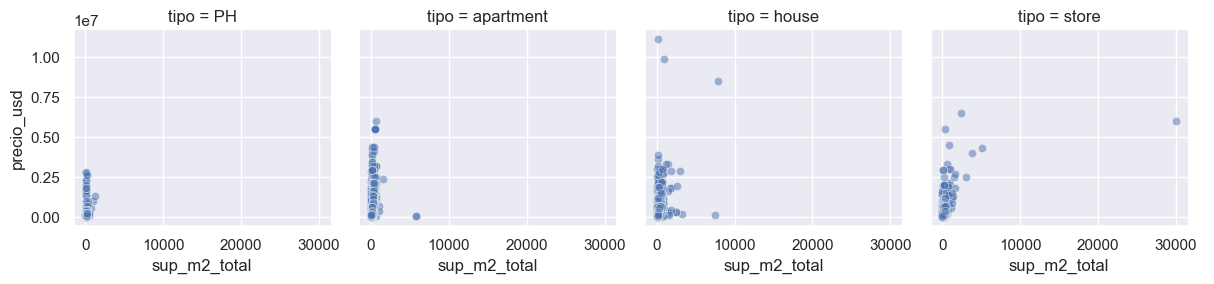

In [22]:
# Realizamos los siguientes graficos para visualizar mejor (zoom) las relaciones- En primera medida analizmos metros totales con precio en dolares
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "sup_m2_total", "precio_usd", alpha=.5)
g.add_legend()

#

PENDIENTE: QUE HACEMOS CON LOS OUTLIERS DE ABAJO. SI BORRAMOS ESE CODIGO O LO PASAMOS A ABAJO

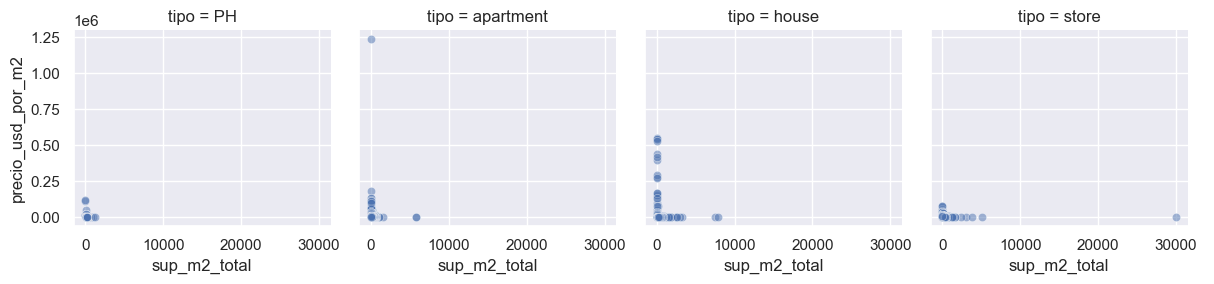

In [23]:
#
# data= data[(data["precio_usd"] >100) & (data["precio_usd"]<= 4.500000e+05)]
# data= data[(data["precio_usd_por_m2"] > 100) & (data["precio_usd_por_m2"]<= 2.500000e+04)]
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "sup_m2_total", "precio_usd_por_m2", alpha=.5)
g.add_legend()

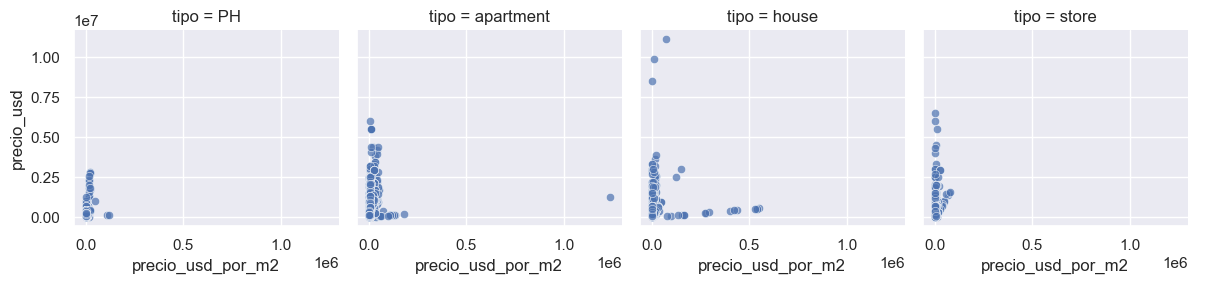

In [24]:
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "precio_usd_por_m2", "precio_usd", alpha=.7)
g.add_legend()

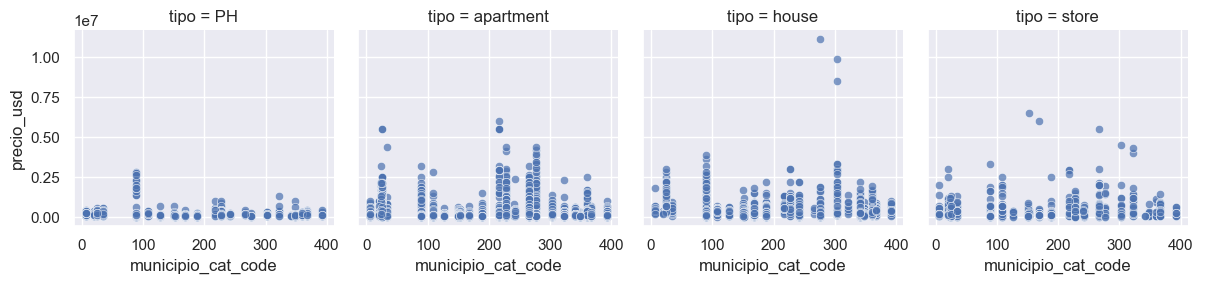

In [25]:
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "municipio_cat_code", "precio_usd", alpha=.7)
g.add_legend()

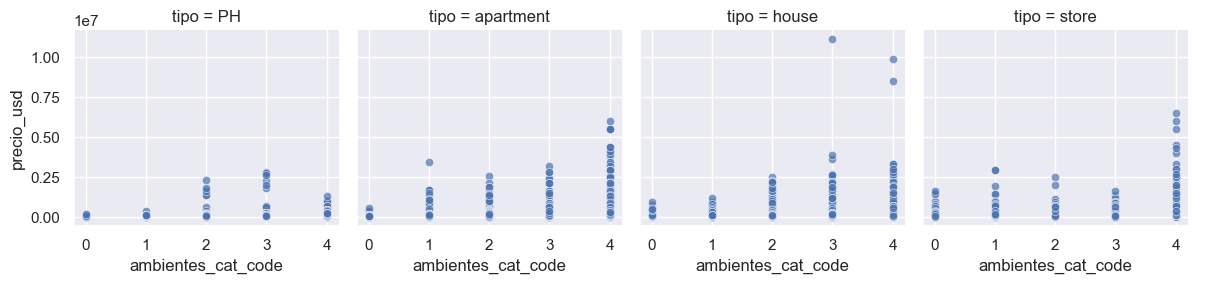

In [26]:
g = sns.FacetGrid(data, col="tipo")
g.map(sns.scatterplot, "ambientes_cat_code", "precio_usd", alpha=.7)
g.add_legend()

PENDIENTE: QUE HACEMOS CON LOS CAMPOS COMENTADOS. LOS ELIMINAMOS O LOS DEJAMOS ABAJO PARA MOSTRAR COSAS QUE NO TUVIERON EXITO?

In [27]:
# masc_dep = data[data["tipo"]=="apartment"]
# sns.scatterplot(data=masc_dep, x='sup_m2_total', y='precio_usd', palette="deep")
# plt.grid()
# plt.show()

In [28]:
# manf_sort = pd.get_dummies(data['ambientes_cat_code']).sum().sort_values(ascending = False)
# plt.figure(figsize=(5,5))
# sns.barplot(x = manf_sort.index, y = manf_sort.values)
# plt.show()

In [29]:
# manf_sort = pd.get_dummies(data['ambientes_cat']).sum().sort_values(ascending = False)
# plt.figure(figsize=(5,5))
# sns.barplot(x = manf_sort.index, y = manf_sort.values)

# plt.show()

In [30]:
#masc_barrio = data[data["municipio"]=="Almagro"]
#sns.scatterplot(data=masc_barrio, x='sup_m2_total', y='precio_usd', palette="deep")
#plt.grid()
#plt.show()

In [31]:
# masc_barrio = data[data["municipio"]=="Almagro"]
# sns.set_style('darkgrid')
# plt.figure(figsize=(6, 4))
# sns.boxplot(data=masc_barrio, x= "tipo", y="sup_m2_total")

# plt.xlabel("tipo")
# plt.ylabel("sup_m2_total")
# plt.title("Superficie total por tipo de inmueble ")

In [32]:
# masc_barrio = data[data["municipio"]=="Almagro"]
# sns.set_style('darkgrid')
# plt.figure(figsize=(6, 4))
# sns.boxplot(data=masc_barrio, x= "tipo", y="precio_usd_por_m2")

# plt.xlabel("tipo")
# plt.ylabel("precio_usd_por_m2")
# plt.title("Precio/m2 por tipo de inmueble ")

In [33]:
# masc_barrio = data[data["municipio"]=="Lomas de Zamora"]
# sns.scatterplot(data=masc_barrio, x='sup_m2_total', y='precio_usd', palette="deep")
# plt.grid()
# plt.show()

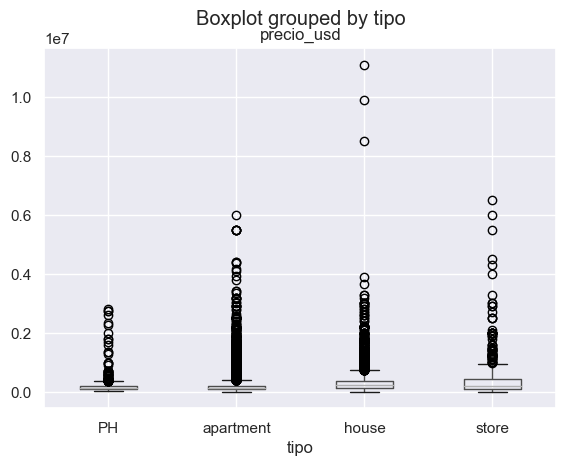

In [34]:
#mostramos un boxplot para los outliers por tipo de propiedad
data.boxplot(column= "precio_usd", by="tipo") 
plt.show()

#### la variable target debe tener una distribucion cercana a la normal

<AxesSubplot:xlabel='precio_usd', ylabel='Count'>

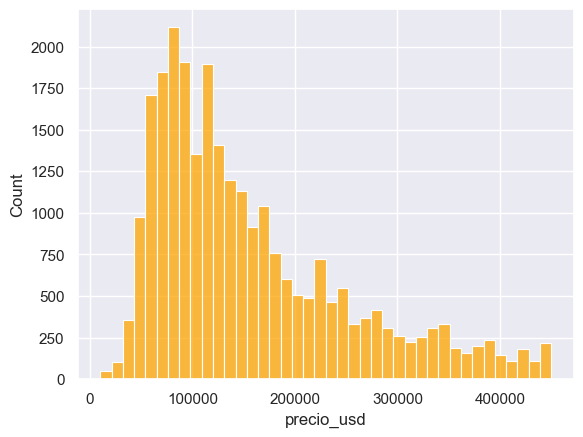

In [35]:
#de acuerdo con los valores minimos y maximos realizamos un histograma para ver la distrubicón de datos de precio_usd
data_2= data[(data["precio_usd"] >10000) & (data["precio_usd"]<= 4.500000e+05)]
sns.histplot(data_2["precio_usd"], color = "orange", bins = 40)

<AxesSubplot:xlabel='sup_m2_total', ylabel='Count'>

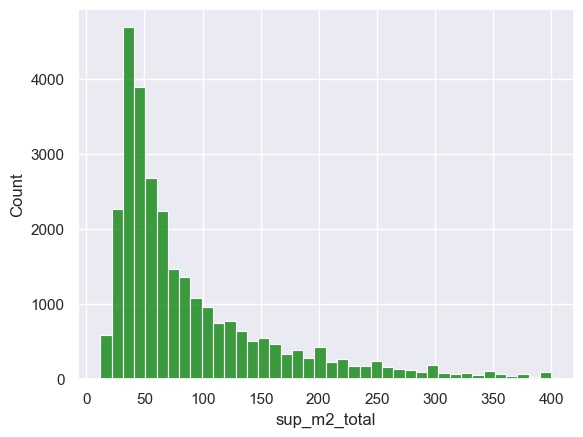

In [36]:
#de acuerdo con los valores minimos y maximos realizamos un histograma para ver la distrubicón de datos de superficie total
data_2= data[(data["sup_m2_total"] >10) & (data["sup_m2_total"]<= 400)]
sns.histplot(data_2["sup_m2_total"], color = "green", bins = 40)

<AxesSubplot:xlabel='precio_usd_por_m2', ylabel='Count'>

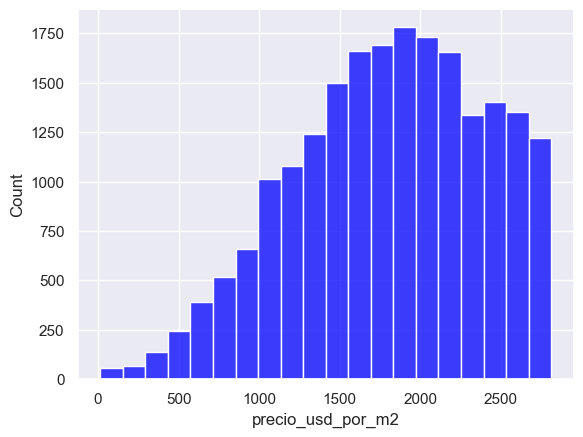

In [37]:
data_2= data[(data["precio_usd_por_m2"] >10) & (data["precio_usd_por_m2"]<= 2.812500e+03)]
sns.histplot(data_2["precio_usd_por_m2"], color = "blue", bins = 20)


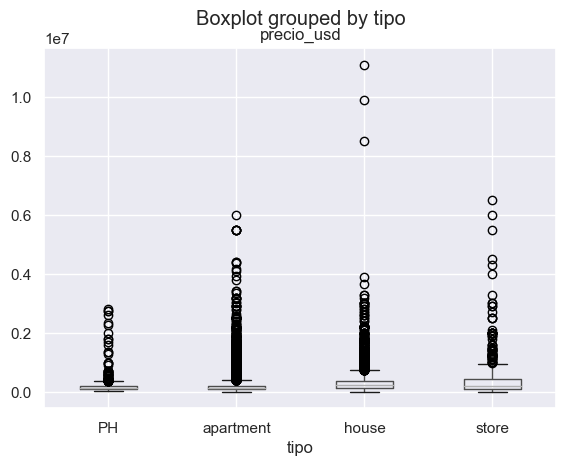

In [38]:
data.boxplot(column= "precio_usd", by="tipo") 
plt.show()

In [39]:

#sns.histplot(data['ambientes_cat'], bins = 5);

In [40]:
#masc_barrio = data[data["municipio"]=="Tigre"]
#sns.scatterplot(data=masc_barrio, x='sup_m2_total', y='precio_usd', palette="deep")
#plt.grid()
#plt.show()

Conclusiones del análisis de variables predictoras y target:
- La mayor cantidad de registros están Capital Federal para los barrios de Palermo, Belgrano, Caballito. Seleccionaremos el barrio XXXX por motivos:XXXXX (PENDIENTE)
- Utilizaremos departamentos como el tipo de inmueble a modelar por contener una mayor cantidad de datos
- Consideraremos como variables predictoras: Superficie total y precio usd por su alta correlación, y su distribución. Luego evaluaremos el impacto de las variables de ubicacion y ambientes.


# Analisis de regresiones sobre el dataset

## Regresión lineal simple

#### Iniciamos con un barrio de Capital Federal con una cantidad de registros mayor a 500 para ver como resulta la regresion utilizando todos los tipos de propiedades de caballito

In [41]:
# data_Caballito = data[data['municipio'] == 'Caballito']
# data_Caballito.to_csv('./data/data_limpio_gdf_caballito.csv', index=False)

In [42]:
#leemos el df creado para el barrio de caballito
df = pd.read_csv('./data/data_limpio_gdf_caballito.csv')

Comparamos un modelo de regresion simple sin division de los regitros y un modelo con train_split_train

In [58]:
#generamos la regresion simple para el barrio caballito usando como variable predictora la superfice total
#sin realizar un train_test_split para ver como dan los resultados
X = df[['sup_m2_total']]
y = df['precio_usd']

# Importamos, Instanciamos, Fiteamos, etc..

# Instanciamos el modelo.
lm = linear_model.LinearRegression()

# Fiteamos el modelo sobre los vectores X e y.
model = lm.fit(X, y)
#
# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictions = lm.predict(X)

# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', model.intercept_)
print ('b_sup_m2_total=', ' ', model.coef_)
# imprimos la metrica que mide la bondad de ajusto del modelo. En este caso el R2.
print ('R2=','', model.score(X, y))
print ("EMC:", mean_squared_error(y, predictions))
print ("r_EMC:", np.sqrt(mean_squared_error(y, predictions)))

Intercepto=   67093.60693187756
b_sup_m2_total=   [1693.97626396]
R2=  0.408557790445238
EMC: 15412770977.64445
r_EMC: 124148.1815317665


PENDIENTE: SI DEJAMOS LA FUNCION DE LUIS QUIZAS COLOCAR ESTE PUNTO ANTERIOR ES REPETITIVO???? ADEMAS PUEDE PRESTAR A CONFUSION XQ DAN R2 DIFERENTES YA QUE EN LA FUNCION SE APLICA UN FILTRO A LOS DATOS

In [56]:
# #Realizamos el modelo de regresion utilizando train_test_split para los mismos datos 

# # Asignamos la variable a predecir - PENDIENTE: BORRAMOS XQ ESTA REPETIDO ARRIBA?
# y = df['precio_usd']
# # Asignamos la variable predictora
# X_simple = df[['sup_m2_total']]

# # Dividimos el dataset en train y test
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)
# Instanciamos el modelo y lo entrenamos

lr = linear_model.LinearRegression()
lr.fit(X_train_1, y_train_1)

# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictions_1 = lr.predict(X)

In [57]:
# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', lr.intercept_)
print ('b_sup_m2_total=', ' ', lr.coef_)
# imprimos la metrica que mide la bondad de ajusto del modelo. En este caso el R2.
print ('R2_train=', ' ', lr.score(X_train_1, y_train_1))
print ('R2_test=', ' ', lr.score(X_test_1, y_test_1))
print ("EMC:", mean_squared_error(y, predictions_1))
print ("r_EMC:", np.sqrt(mean_squared_error(y, predictions_1)))

Intercepto=   66074.68286044807
b_sup_m2_total=   [1713.60922343]
R2_train=   0.37807640238760565
R2_test=   0.6022845532195175
EMC: 15414357219.315987
r_EMC: 124154.56986883724


Los resultados del coeficiente en ambos modelos no son tan diferentes, indican que por cada m2 de superficie total el valor del precio en dolares aumenta en 1713 unidades al hacer la separacion de datos y aprox 1693 unid al modelar todos los datos
El R2 de entrenamiento disminuye de 0.41 a 0.37 al hacer la separacion de los datos en train_test-_split. 
Cuando se determina el R2 en los datos no entrenados tenemos una respuesta del 60% de que nuestra variable objetivo es explicada por el modelo
En este caso preferimos usar la raiz de EMC ya que los precios estan en el orden de 1e7.

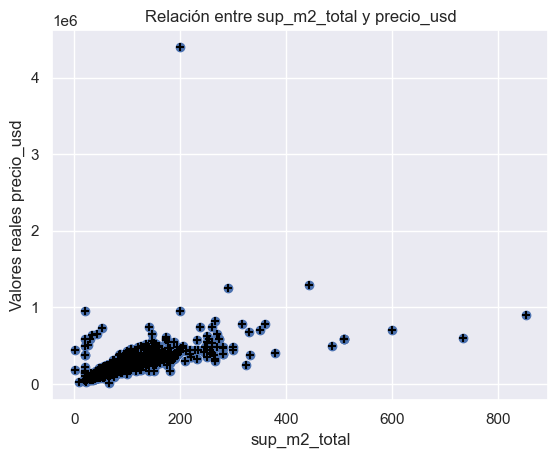

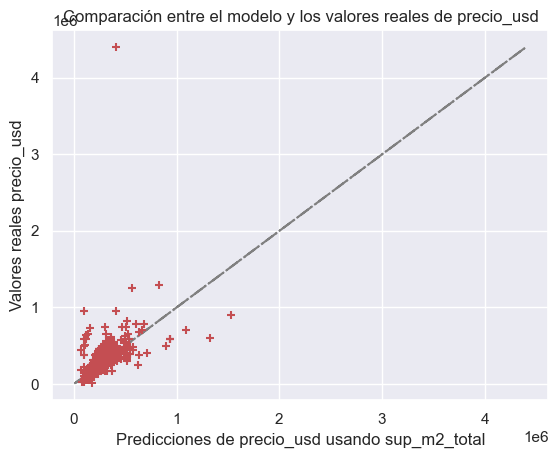

In [46]:
# Graficamos la variable X contra la variable Y, 
plt.scatter(X, y, s=30, c='black', marker='+', zorder=10)
plt.scatter(X, y)
plt.xlabel("sup_m2_total")
plt.ylabel("Valores reales precio_usd")
plt.title('Relación entre sup_m2_total y precio_usd')
plt.show()

# Graficamos el modelo re regresion del modelo con train_test_split
plt.plot(y,y, '-.',c='grey')
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de precio_usd usando sup_m2_total")
plt.ylabel("Valores reales precio_usd")
plt.title('Comparación entre el modelo y los valores reales de precio_usd')
plt.show()

El primer gráfico nos permite ver el tipo de relacion entre la variable predictora y la variable objetivo. Se observa que hay cierta correlación entre ellas, pero estan influenciadas por los valores extremos. 
 
 El segundo gráfico es la comparación entre el valor real de precio en dolares  vs el valor predicho por nuestro modelo. 
 Puede verse que existe la correlación entre las variables pero existe el ruido de los valores extremos.

### Separamos por tipo de inmueble
Realizamos un filtro en el tipo de inmueble para ver si existen cambios en el modelo: nos quedamos con departamentos que para el barrio caballito cuenta con mas de 1500 registros

In [47]:
#Solo para departamentos
tipo_dept = ["apartment"]
df_2 = df[df["tipo"].isin(tipo_dept)]

In [48]:
# Asignamos la variable a predecir
y_d = df_2['precio_usd']
# Asignamos la variable predictora
X_d = df_2[['sup_m2_total']]
# Dividimos el dataset en train y test

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_d, y_d, test_size=0.2, random_state=42)

# Instanciamos el modelo y lo entrenamos

lr_d = linear_model.LinearRegression()
lr_d.fit(X_train_2, y_train_2)

# Guardamos  las predicciones en un nuevo vector que llamaremos predictions.
predictions_d = lr_d.predict(X_d)

In [49]:
# Imprimimos el intercepto y los coeficientes como atributos del objeto entrenado.
print ('Intercepto=', ' ', lr_d.intercept_)
print ('sup_m2_total=', ' ', lr_d.coef_)

# imprimos la metrica que mide la bondad de ajusto del modelo. En este caso el R2.

print ('R2_train=', ' ', lr_d.score(X_train_2, y_train_2))
print ('R2_test=', ' ', lr_d.score(X_test_2, y_test_2))
print ("EMC:", mean_squared_error(y_d, predictions_d))
print ("r_EMC:", np.sqrt(mean_squared_error(y_d, predictions_d)))

Intercepto=   6965.025287725235
sup_m2_total=   [2669.81548494]
R2_train=   0.38756871666468673
R2_test=   0.8050987381134348
EMC: 12795436953.133234
r_EMC: 113116.91718365221


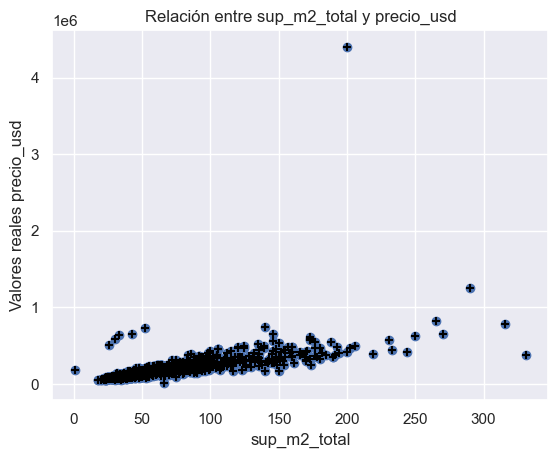

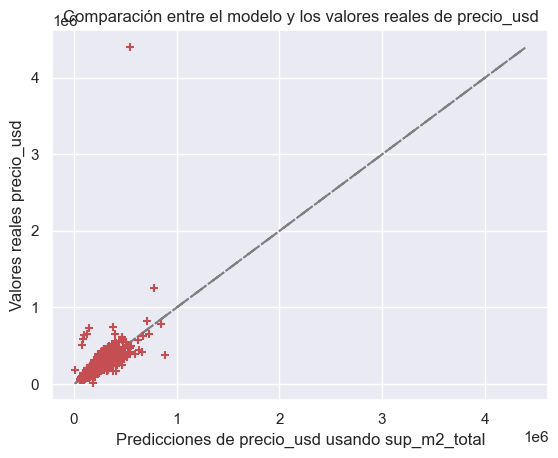

In [50]:
# Graficamos la variable X contra la variable Y
plt.scatter(X_d, y_d, s=30, c='black', marker='+', zorder=10)
plt.scatter(X_d, y_d)
plt.xlabel("sup_m2_total")
plt.ylabel("Valores reales precio_usd")
plt.title('Relación entre sup_m2_total y precio_usd')
plt.show()

# Graficamos el modelo
plt.plot(y_d,y_d, '-.',c='grey')
plt.scatter(predictions_d, y_d, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicciones de precio_usd usando sup_m2_total")
plt.ylabel("Valores reales precio_usd")
plt.title('Comparación entre el modelo y los valores reales de precio_usd')
plt.show()

## Regresión lineal múltiple

Agregamos a la correlacion las variables latitud y longitud

In [59]:
# Asignamos las variables predictoras

X_3 = df_2[['lat', 'lon', 'sup_m2_total']]

y_3 = df_2['precio_usd']

# Normalizamos los datos

scaler = StandardScaler()
scaler.fit(X_3)
X_3 = scaler.transform(X_3)

# Dividimos en train y test

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

# Instanciamos el modelo y lo entrenamos

lr_2= linear_model.LinearRegression()
lr_2.fit(X_train_3, y_train_3)

# Vemos los coeficientes

print('Coeficientes: ', lr_2.coef_)
print('Intercepto: ', lr_2.intercept_)
print('R2_train: ', r2_score(y_train_3, lr_2.predict(X_train_3)))
print('R2_test: ', r2_score(y_test_3, lr_2.predict(X_test_3)))
print ('MSE:', metrics.mean_squared_error(y_3, lr_2.predict(X_3)))
print ('rMSE:', np.sqrt(metrics.mean_squared_error(y_3, lr_2.predict(X_3))))


Coeficientes:  [ 1246.39563139  2285.9746892  99829.67877515]
Intercepto:  176189.90623887416
R2_train:  0.38776454432583496
R2_test:  0.8055359047426797
MSE: 12790464252.378803
rMSE: 113094.93468930783


In [61]:
# Modelamos con statsmodels

X_train_sm = sm.add_constant(X_train_3)

model = sm.OLS(y_train_3, X_train_sm).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             precio_usd   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     262.4
Date:                Fri, 02 Dec 2022   Prob (F-statistic):          6.52e-132
Time:                        01:39:47   Log-Likelihood:                -16396.
No. Observations:                1247   AIC:                         3.280e+04
Df Residuals:                    1243   BIC:                         3.282e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.762e+05   3522.074     50.024      0.0

Ciomparando la regresion multiple sencilla con la regresión OLS podemos observar como OLS nos permite validar la significancia de los datos obtenidos. Vemos con los p values para las variables latitud y longitud son mayores al nivel de significancia por lo cual estas variables no están explicando o no tiene valor de predicción sobre el valor de nuestra variable objetivo precio en dolares.
El 
AL incluir latitud y longitud disminuye el performance del R2 a 0,38 en la regresion multiple.

Usamos OLS para ver como resultan las metricas al usar solo la variable superficie total

In [62]:
# Probamos con regularización ridge

lm_ridge = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))

model_ridge = lm_ridge.fit(X_train_3, y_train_3)

print(lm_ridge.alpha_)
print(lm_ridge.coef_)
print(lm_ridge.intercept_)

10.0
[ 1210.83364602  2300.38534583 99015.57189861]
176191.53028460857


In [63]:
model_ridge.score(X_test_3, y_test_3)

0.8064751029212361

In [64]:
# Probamos con regularización lasso

lm_lasso = linear_model.LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)

model_lasso = lm_lasso.fit(X_train_3, y_train_3)

print(lm_lasso.alpha_)
print(lm_lasso.coef_)

print(lm_lasso.intercept_)

1000.0
[    0.           939.52248241 98834.27988238]
176198.71223799104


In [65]:
model_lasso.score(X_test_3, y_test_3)

0.8069357932371325

#### Analizaremos el impacto de la variables ambientes en la predicción de la variable precio. 

In [66]:
# Creamos las variables dummies para la variable categórica de ambientes
df_0_ambientes_cat = pd.get_dummies(df_0_ambientes_cat, columns=['ambientes_cat'], drop_first=True)
print(df_0_ambientes_cat.shape)
df_0_ambientes_cat.head()

(29360, 6)


,precio_usd,municipio,ambientes_cat_1,ambientes_cat_2,ambientes_cat_3,ambientes_cat_4 o mas
2,130000.0,Vicente López,0,0,1,0
3,138000.0,Belgrano,1,0,0,0
4,195000.0,Belgrano,0,1,0,0
6,115000.0,San Isidro,0,1,0,0
9,570000.0,Tigre,0,0,0,1


In [67]:
df_3 = pd.concat([df_2["sup_m2_total"],df_0_ambientes_cat],axis=1)
df_3.head(4)

,sup_m2_total,precio_usd,municipio,ambientes_cat_1,ambientes_cat_2,ambientes_cat_3,ambientes_cat_4 o mas
0,50.0,NaN,NaN,NaN,NaN,NaN,NaN
1,46.0,NaN,NaN,NaN,NaN,NaN,NaN
2,75.0,130000.0,Vicente López,0.0,0.0,1.0,0.0
3,75.0,138000.0,Belgrano,1.0,0.0,0.0,0.0


In [86]:
# Asignamos las variables predictoras

X_amb = df_3[['ambientes_cat_1', 'ambientes_cat_2', 'ambientes_cat_3', 'ambientes_cat_4 o mas','sup_m2_total']]
y = df_2['precio_usd']


In [75]:
# Normalizamos los datos

scaler = StandardScaler()
scaler.fit(X_amb)
X_amb = scaler.transform(X_amb)


PENDIENTE. SALE ERROR EN ESTE SPLIT. LUIS PODES REVISAR DONDE METI MAL EL DEDO-GRACIASSS

In [78]:
# Dividimos en train y test

X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_amb, y, test_size=0.2, random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [30003, 1559]

In [ ]:
# Instanciamos el modelo y lo entrenamos

lr_4 = linear_model.LinearRegression()
lr_4.fit(X_train_4, y_train_4)


In [ ]:
# Vemos los coeficientes

print('Coeficientes: ', lr_4.coef_)
print('Intercepto: ', lr_4.intercept_)

In [ ]:
# Calculamos el R2

print('R2: ', r2_score(y_test_4, lr_4.predict(X_test_4)))


In [ ]:
# Modelamos con statsmodels

X_train_sm_2 = sm.add_constant(X_train_4)
model_2 = sm.OLS(y_train, X_train_sm_2).fit()

model_2.summary()

In [ ]:
# Probamos con regularización ridge

lm_ridge_2 = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))

model_ridge_2 = lm_ridge.fit(X_train_4, y_train_4)

lm_ridge_2.alpha_

In [ ]:
model_ridge.score(X_test_4, y_test_4)

In [ ]:
# Probamos con regularización lasso

lm_lasso_2 = linear_model.LassoCV(alphas=np.logspace(-6, 6, 13), cv=5)

model_lasso_2 = lm_lasso_2.fit(X_train_4, y_train_4)

lm_lasso_2.alpha_

In [ ]:
model_lasso_2.score(X_test_4, y_test_4)

PENDIENTE- VER SI AJUSTAMOS EL MODELO REDUCIENDO LA CANTIDAD DE DATOS

In [ ]:
# superficie_min=15
# superficie_max=1000

# data = data[(data.sup_m2_total <= 1000) & (data.sup_m2_total >= 15)]

# data = data[(data.precio_usd <= 4000000)]

In [ ]:
# # Generamos una función que resume los coeficientes, el intercepto y el R2
# # "model" = objeto con el modelo
# # "X" = matrix de variables independientes

# def sum_mod(lr, X):
#     a = pd.DataFrame(lr.coef_ , X_simple.columns.values)
#     a = a.append(pd.DataFrame([lr.intercept_, lr.score(X_simple, y)], index=['Intecept','R2']))
#     return(a)